In [1]:
from pprint import pprint


import matplotlib.pyplot as plt

import numpy as np


import hoho
from hoho import compute_WED
from hoho import vis
from hoho.vis import line

from scipy.spatial.distance import cdist
import cv2
hoho.LOCAL_DATADIR = hoho.setup("../data")
from handcrafted_solution import predict
from tqdm import tqdm

Using ..\data as the data directory (we are running locally)


In [ ]:
# from ..s23dr-hoho-competition import handcrafted_solution

In [6]:
split = "val"

dataset = hoho.get_dataset(decode=None, split=split)
import webdataset as wds

targets = wds.WebDataset("../data/val/targets/hoho_v3_025-of-032.tar.gz")

In [4]:


for i, sample in tqdm(enumerate(dataset)):
    # if i > 170:
    predict(sample, visualize=False, point_radius=40, max_angle=5)

2it [00:02,  1.25s/it]

Not enough vertices or connections in image 1


4it [00:07,  1.85s/it]


KeyboardInterrupt: 

In [3]:
from pathlib import Path

solution = []
from concurrent.futures import ProcessPoolExecutor
with ProcessPoolExecutor(max_workers=11) as pool:
    results = []
    for i, sample in enumerate(tqdm(dataset)):
        results.append(pool.submit(predict, sample, visualize=False, point_radius=20, max_angle=5, extend=20))

    for i, result in enumerate(tqdm(results)):
        key, pred_vertices, pred_edges = result.result()
        solution.append({
            '__key__': key,
            'wf_vertices': pred_vertices.tolist(),
            'wf_edges': pred_edges
        })
        # if i % 100 == 0:
            # incrementally save the results in case we run out of time
            # print(f"Processed {i} samples")
            # save_submission(solution, Path(params['output_path']) / "submission.parquet")    

346it [00:12, 28.11it/s] 
100%|██████████| 346/346 [01:24<00:00,  4.10it/s]


In [13]:
from script import save_submission

In [14]:
print('------------ Saving results ---------------')
save_submission(solution, "submission.parquet")
print("------------ Done ------------ ")


------------ Saving results ---------------
Submission saved to submission.parquet
------------ Done ------------ 


[{'__key__': 'ac398eacc02',
  'wf_vertices': [[-656.7050599672618, -605.098754169388, 243.92722906250577],
   [-270.3944092135496, -517.9822255731817, 269.22916207140025],
   [-179.18750033628248, -1394.6868022716815, 374.49496362478897],
   [-487.79387210297637, -1263.613806359354, 285.6131299095989],
   [-825.5136601675167, -954.9844714789193, 203.81423465216574],
   [-872.5067983535567, -1016.2934509036636, 84.66995230858376],
   [255.8133866747114, -1346.719177970111, 412.91042389741824],
   [485.9028287150579, -1531.3825528818056, 138.89326089772047],
   [1567.9935647986138, 559.751036081686, 100.23215302448351],
   [1415.6798411145587, 566.6877693497729, 99.32366541890012],
   [1545.8014993390966, 437.66785057025766, 139.58939347759275],
   [1516.716302070865, 561.7094174542095, 107.84276299884189],
   [1510.6712398820182, 804.3431414136203, 117.81207290756922],
   [1518.4102006603268, 731.4309845567738, 105.0991532914263],
   [1335.6419936963762, 805.8892733753611, 78.6334695275

In [19]:
for i in [*hoho.get_dataset(decode=None, split=split)]:
    print(i)

{'__key__': <class 'str'>, '__imagekey__': [<class 'str'>], '__url__': <class 'str'>, 'ade20k': [<class 'bytes'>], 'depthcm': [<class 'bytes'>], 'gestalt': [<class 'bytes'>], 'K': (4, 3, 3), 'R': (4, 3, 3), 't': (4, 3), 'images': <class 'bytes'>, 'points3d': <class 'bytes'>, 'cameras': <class 'bytes'>}
{'__key__': <class 'str'>, '__imagekey__': [<class 'str'>], '__url__': <class 'str'>, 'ade20k': [<class 'bytes'>], 'depthcm': [<class 'bytes'>], 'gestalt': [<class 'bytes'>], 'K': (3, 3, 3), 'R': (3, 3, 3), 't': (3, 3), 'images': <class 'bytes'>, 'points3d': <class 'bytes'>, 'cameras': <class 'bytes'>}
{'__key__': <class 'str'>, '__imagekey__': [<class 'str'>], '__url__': <class 'str'>, 'ade20k': [<class 'bytes'>], 'depthcm': [<class 'bytes'>], 'gestalt': [<class 'bytes'>], 'K': (5, 3, 3), 'R': (5, 3, 3), 't': (5, 3), 'images': <class 'bytes'>, 'points3d': <class 'bytes'>, 'cameras': <class 'bytes'>}
{'__key__': <class 'str'>, '__imagekey__': [<class 'str'>], '__url__': <class 'str'>, 'a

IndexError: list index out of range

345

In [25]:
for i in hoho.get_dataset(decode=None, split=split):
    print(i)
    break

{'__key__': <class 'str'>, '__imagekey__': [<class 'str'>], '__url__': <class 'str'>, 'ade20k': [<class 'bytes'>], 'depthcm': [<class 'bytes'>], 'gestalt': [<class 'bytes'>], 'K': (4, 3, 3), 'R': (4, 3, 3), 't': (4, 3), 'images': <class 'bytes'>, 'points3d': <class 'bytes'>, 'cameras': <class 'bytes'>}


In [7]:
import io
solution_dict = {}
for d in solution[:173]:
    solution_dict[d["__key__"]] = d
# for d in solution[173:]:
#     solution_dict[d["__key__"]] = {"wf_vertices":[[0,100,0], [0,-100,0], [100,0,0], [-100,0,0]], "wf_edges": [(0, 2), (2, 1), (1, 3), (3, 0)]}
WEDs = []

for i in targets:
    try:
        j = solution_dict[i["__key__"]]
        i = dict(np.load(io.BytesIO(i["wireframe.npz"])))
        WEDs.append(hoho.compute_WED(j["wf_vertices"], j["wf_edges"], i["wf_vertices"], i["wf_edges"]))
    except KeyError:
        pass
    

In [27]:
WEDs

[2.676034058193981,
 1.9350219092383154,
 1.8641915552589836,
 3.015960463447758,
 2.6667933167949074,
 1.232501046717596,
 1.876056598343252,
 3.231162116017275,
 2.4075650268031743,
 2.763288700454399,
 2.4096106118660536,
 2.766497985653837,
 3.3857620156098456,
 2.309454744250443,
 2.338425158810963,
 2.6979664103316043,
 2.2129751544721206,
 2.6537780479649222,
 2.2122967796132564,
 2.3715253041919144,
 2.382578793019074,
 2.664659634690259,
 2.6368028763474283,
 2.0494952355773743,
 2.4238855485528115,
 2.886649171133775,
 2.533104053762428,
 2.154532536609055,
 2.0658467160149874,
 2.756268408052827,
 2.94621099259946,
 2.779834796092198,
 1.7262697347930969,
 2.8671280324353443,
 3.0385726729158837,
 3.536296292868906,
 2.7769325472016924,
 2.1031188484341534,
 2.0413140683322344,
 2.250374268963779,
 3.3560037434886967,
 2.4365502343268313,
 2.1795662616748643,
 2.229457665889459,
 2.179593064547988,
 3.047780592465948,
 1.5819513238597034,
 1.622956553209701,
 1.8513520447040

In [8]:
import scipy.stats as ss

ss.describe(WEDs)

DescribeResult(nobs=173, minmax=(1.3277926313096529, 3.6261780809782476), mean=2.3922155425953786, variance=0.22032420003471148, skewness=0.14340784428616138, kurtosis=-0.5120992116516523)

(array([ 6., 12., 24., 37., 35., 17., 23., 10.,  6.,  3.]),
 array([1.2885549 , 1.54589969, 1.80324448, 2.06058926, 2.31793405,
        2.57527884, 2.83262362, 3.08996841, 3.34731319, 3.60465798,
        3.86200277]),
 <BarContainer object of 10 artists>)

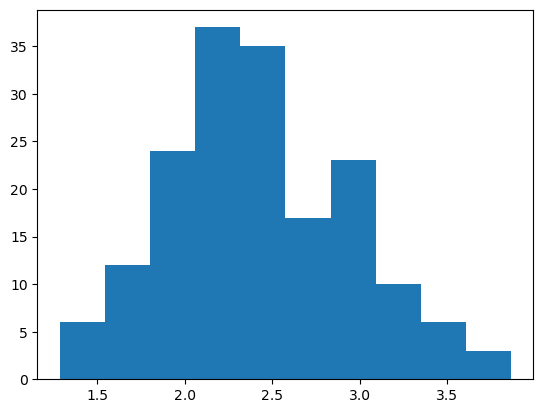

In [24]:
plt.hist(WEDs)

In [80]:
WEDs

[2.2229805695077083,
 1.9514464996164573,
 1.7590658149651095,
 3.1405426461515633,
 2.8183054907145473,
 1.140120966164992,
 2.1558598709479813,
 3.3662869370814827,
 2.3891611651819735,
 2.275638964174794,
 2.1483604574233124,
 2.628918854537702,
 3.1136525432670066,
 2.1715716989266127,
 2.438280253712535,
 2.653076550893886,
 1.9852997999356443,
 2.644463567775789,
 2.2122967796132564,
 2.3063106133427045,
 2.518780917419762,
 2.173287036879083,
 2.5362215037708,
 2.0293073338156344,
 2.1645267490995206,
 2.3771093706013082,
 2.693419063975656,
 2.131319438324366,
 1.803577113450096,
 2.170475125298135,
 2.837187660790624,
 2.902589943407295,
 2.749964377946793,
 2.8058926261061226,
 2.958089603803645,
 3.243547730539942,
 3.4913308530124443,
 1.987038402928909,
 2.0877151308757904,
 2.067962649465477,
 2.747934312119973,
 2.801020542277625,
 2.1139353030967962,
 2.301493743300777,
 2.195098303241758,
 2.1529734033032097,
 1.5749234936721188,
 1.5727846791999307,
 1.519615355101089

[{'__key__': 'ac398eacc02',
  'wf_vertices': [[-656.7050599672618, -605.098754169388, 243.92722906250577],
   [-270.3944092135496, -517.9822255731817, 269.22916207140025],
   [-179.18750033628248, -1394.6868022716815, 374.49496362478897],
   [-487.79387210297637, -1263.613806359354, 285.6131299095989],
   [-825.5136601675167, -954.9844714789193, 203.81423465216574],
   [-872.5067983535567, -1016.2934509036636, 84.66995230858376],
   [255.8133866747114, -1346.719177970111, 412.91042389741824],
   [485.9028287150579, -1531.3825528818056, 138.89326089772047],
   [1567.9935647986138, 559.751036081686, 100.23215302448351],
   [1415.6798411145587, 566.6877693497729, 99.32366541890012],
   [1545.8014993390966, 437.66785057025766, 139.58939347759275],
   [1516.716302070865, 561.7094174542095, 107.84276299884189],
   [1510.6712398820182, 804.3431414136203, 117.81207290756922],
   [1518.4102006603268, 731.4309845567738, 105.0991532914263],
   [1335.6419936963762, 805.8892733753611, 78.6334695275

# grid search

In [9]:
wed_stats = {}


for radius in range(10, 50, 5):
    for angle in range(1, 10):
        for extend in range(0, 40, 10):
            solution = []

            with ProcessPoolExecutor(max_workers=12) as pool:
                results = []
                for i, sample in enumerate(tqdm(dataset)):
                    results.append(pool.submit(predict, sample, visualize=False, point_radius=radius, max_angle=angle, extend=extend))
            
                for i, result in enumerate(tqdm(results)):
                    key, pred_vertices, pred_edges = result.result()
                    solution.append({
                        '__key__': key,
                        'wf_vertices': pred_vertices.tolist(),
                        'wf_edges': pred_edges
                    })
            
            solution_dict = {}
            for d in solution[:173]:
                solution_dict[d["__key__"]] = d
            WEDs = []
            
            for i in targets:
                try:
                    j = solution_dict[i["__key__"]]
                    i = dict(np.load(io.BytesIO(i["wireframe.npz"])))
                    WEDs.append(hoho.compute_WED(j["wf_vertices"], j["wf_edges"], i["wf_vertices"], i["wf_edges"]))
                except KeyError:
                    pass

            wed_stats[(radius, angle, extend)] = ss.describe(WEDs)

100%|██████████| 346/346 [01:16<00:00,  4.50it/s]
346it [00:11, 29.01it/s] 
100%|██████████| 346/346 [01:14<00:00,  4.62it/s]
346it [00:11, 29.20it/s] 
100%|██████████| 346/346 [01:14<00:00,  4.66it/s]
346it [00:11, 29.43it/s] 
100%|██████████| 346/346 [01:16<00:00,  4.54it/s]
346it [00:12, 28.72it/s] 
100%|██████████| 346/346 [01:14<00:00,  4.64it/s]
346it [00:11, 29.44it/s] 
100%|██████████| 346/346 [01:18<00:00,  4.43it/s]
346it [00:11, 29.12it/s] 
100%|██████████| 346/346 [01:18<00:00,  4.40it/s]


In [10]:
print(wed_stats)

{(10, 1, 0): DescribeResult(nobs=173, minmax=(0.9504744679463277, 4.2688324308036), mean=2.918631217038793, variance=0.2655104551963414, skewness=-0.5301066567004962, kurtosis=0.6648724709751717), (10, 1, 10): DescribeResult(nobs=173, minmax=(1.217735384196255, 4.095658947639928), mean=2.756003469399469, variance=0.28989047602798246, skewness=-0.2945369702420912, kurtosis=-0.02369081827086239), (10, 1, 20): DescribeResult(nobs=173, minmax=(1.1905609076446098, 3.832138275353508), mean=2.7507068339662806, variance=0.25787775042947936, skewness=-0.37508484769566325, kurtosis=-0.03210901516830633), (10, 1, 30): DescribeResult(nobs=173, minmax=(1.7501416446074862, 4.191259803191946), mean=2.961261234054409, variance=0.2398959796022379, skewness=-0.1092311580556235, kurtosis=-0.26051346232955686), (10, 2, 0): DescribeResult(nobs=173, minmax=(0.9504744679463277, 4.128352337180152), mean=2.9003120200331316, variance=0.261910349388631, skewness=-0.5119892469577535, kurtosis=0.6424781625590157),

In [24]:
min_mean_idx = np.argmin([i.mean for i in wed_stats.values()])
min_mean_idx

143

In [29]:
list(wed_stats.keys())[min_mean_idx]

(25, 9, 30)

In [34]:
len(wed_stats)

288

In [3]:
import pickle

In [37]:
with open("27-03-24_08_41_gridsearch.pkl", "wb") as f:
    pickle.dump(wed_stats, f)

In [4]:
with open("27-03-24_08_41_gridsearch.pkl", "rb") as f:
    wed_stats= pickle.load(f)

In [7]:
sorted(wed_stats.items(), key=lambda x: x[1].mean)

[((25, 9, 30),
  DescribeResult(nobs=173, minmax=(1.3076459810782375, 3.6427458988029624), mean=2.365431389151285, variance=0.24408016546768208, skewness=0.24970843688533947, kurtosis=-0.47489943956804215)),
 ((25, 3, 30),
  DescribeResult(nobs=173, minmax=(1.3277926313096529, 3.5793431626907006), mean=2.365799431760512, variance=0.2283485251258321, skewness=0.14581362181613933, kurtosis=-0.4966945138162737)),
 ((25, 8, 20),
  DescribeResult(nobs=173, minmax=(1.3347463232592418, 3.7489880220512433), mean=2.3666799964968566, variance=0.23256287638977155, skewness=0.2351978824288662, kurtosis=-0.34650790205426807)),
 ((25, 4, 30),
  DescribeResult(nobs=173, minmax=(1.3277926313096529, 3.5559859764406214), mean=2.367685477902936, variance=0.22928262970110813, skewness=0.1234810295855286, kurtosis=-0.6546653426007194)),
 ((35, 2, 10),
  DescribeResult(nobs=173, minmax=(1.3880417275094599, 3.7195088150342186), mean=2.3681322155779267, variance=0.2347349275743601, skewness=0.2734479351216136